In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l2_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l2_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1532
0
26 28 (1, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2817 - total_loss: 0.2817 - reg_loss: 0.2817 - val_loss: 0.2566 - val_total_loss: 0.2566 - val_reg_loss: 0.2566
Epoch 2/100
1532/1532 [==============================] - 18s 12ms/step - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918216  0.010894  0.238289    7  2017-04-16
472     2.507290  2.536693 -0.029402  0.234986    1  2017-04-17
473     2.661330  2.660241  0.001088  0.254229    2  2017-04-18
474     2.754815  2.741499  0.013316  0.208437    3  2017-04-19
475     2.713762  2.713713  0.000049  0.239422    4  2017-04-20
476     2.999000  2.984021  0.014979  0.154306    5  2017-04-21
477     3.075529  3.073298  0.002231  0.187911    6  2017-04-22

0.216797041715
best_epochs [3, 7, 5, 6, 4]
(829, 1) 2.66569628326 

2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1532
0
26 28 (2, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2780 - total_loss: 0.2780 - reg_loss: 0.2780 - val_loss: 0.2441 - val_total_loss: 0.2441 - val_reg_loss: 0.2441
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.943304 -0.014194  0.289472    6  2017-04-15
471     2.507290  2.608919 -0.101629  0.427776    7  2017-04-16
472     2.661330  2.727611 -0.066281  0.353513    1  2017-04-17
473     2.754815  2.766432 -0.011617  0.255864    2  2017-04-18
474     2.713762  2.740230 -0.026469  0.294487    3  2017-04-19
475     2.999000  3.012313 -0.013313  0.199557    4  2017-04-20
476     3.075529  3.090872 -0.015343  0.226203    5  2017-04-21

0.292410192416
best_epochs [7, 3, 6, 5, 1]
(829, 1) 2.54561185945 

3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1532
0
26 28 (3, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2859 - total_loss: 0.2859 - reg_loss: 0.2859 - val_loss: 0.2713 - val_total_loss: 0.2713 - val_reg_loss: 0.2713
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.886814  0.042296  0.268200    5  2017-04-14
470     2.507290  2.542807 -0.035517  0.305658    6  2017-04-15
471     2.661330  2.669516 -0.008186  0.424011    7  2017-04-16
472     2.754815  2.759537 -0.004723  0.343708    1  2017-04-17
473     2.713762  2.748363 -0.034601  0.314663    2  2017-04-18
474     2.999000  2.980812  0.018187  0.201091    3  2017-04-19
475     3.075529  3.065506  0.010023  0.268125    4  2017-04-20

0.303636511302
best_epochs [5, 6, 8, 3, 4]
(829, 1) 2.63019650999 

4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1532
0
26 28 (4, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3391 - total_loss: 0.3391 - reg_loss: 0.3391 - val_loss: 0.2517 - val_total_loss: 0.2517 - val_reg_loss: 0.2517
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.864609  0.064501  0.329016    4  2017-04-13
469     2.507290  2.536561 -0.029271  0.266322    5  2017-04-14
470     2.661330  2.677704 -0.016374  0.296433    6  2017-04-15
471     2.754815  2.688334  0.066481  0.380160    7  2017-04-16
472     2.713762  2.742629 -0.028867  0.346118    1  2017-04-17
473     2.999000  2.978035  0.020965  0.219314    2  2017-04-18
474     3.075529  3.021769  0.053761  0.280531    3  2017-04-19

0.30255624757
best_epochs [5, 7, 8, 3, 9]
(829, 1) 2.68452942317 

5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1532
0
26 28 (5, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2832 - total_loss: 0.2832 - reg_loss: 0.2832 - val_loss: 0.2566 - val_total_loss: 0.2566 - val_reg_loss: 0.2566
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/step -

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.879364  0.049745  0.356749    3  2017-04-12
468     2.507290  2.561687 -0.054397  0.300435    4  2017-04-13
469     2.661330  2.679529 -0.018200  0.287949    5  2017-04-14
470     2.754815  2.768156 -0.013341  0.266445    6  2017-04-15
471     2.713762  2.723298 -0.009536  0.413071    7  2017-04-16
472     2.999000  2.977418  0.021582  0.295492    1  2017-04-17
473     3.075529  3.056640  0.018889  0.279068    2  2017-04-18

0.314172452287
best_epochs [5, 7, 4, 2, 9]
(829, 1) 2.74688727719 

6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 15.1334
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1532
0
26 28 (6, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2902 - total_loss: 0.2902 - reg_loss: 0.2902 - val_loss: 0.2525 - val_total_loss: 0.2525 - val_reg_loss: 0.2525
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.926899  0.002211  0.343715    2  2017-04-11
467     2.507290  2.597811 -0.090521  0.333010    3  2017-04-12
468     2.661330  2.696688 -0.035359  0.311448    4  2017-04-13
469     2.754815  2.783593 -0.028778  0.235482    5  2017-04-14
470     2.713762  2.725917 -0.012155  0.286747    6  2017-04-15
471     2.999000  2.948314  0.050686  0.331602    7  2017-04-16
472     3.075529  3.064513  0.011016  0.347432    1  2017-04-17

0.312776602624
best_epochs [9, 6, 4, 3, 1]
(829, 1) 3.04701716427 

7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 16.3101
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1532
0
26 28 (7, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2867 - total_loss: 0.2867 - reg_loss: 0.2867 - val_loss: 0.2496 - val_total_loss: 0.2496 - val_reg_loss: 0.2496
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.905361  0.023749  0.380672    1  2017-04-10
466     2.507290  2.600377 -0.093087  0.339079    2  2017-04-11
467     2.661330  2.717639 -0.056309  0.334926    3  2017-04-12
468     2.754815  2.764377 -0.009562  0.266274    4  2017-04-13
469     2.713762  2.727578 -0.013816  0.277742    5  2017-04-14
470     2.999000  2.993614  0.005386  0.206107    6  2017-04-15
471     3.075529  3.099660 -0.024130  0.334513    7  2017-04-16

0.305616392729
best_epochs [6, 8, 2, 1, 5]
(829, 1) 3.0221336343 

8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 17.5743
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1532
0
26 28 (8, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 21s 13ms/step - loss: 0.2823 - total_loss: 0.2823 - reg_loss: 0.2823 - val_loss: 0.2591 - val_total_loss: 0.2591 - val_reg_loss: 0.2591
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/step

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  3.013081 -0.083971  0.374951    7  2017-04-09
465     2.507290  2.651014 -0.143724  0.366320    1  2017-04-10
466     2.661330  2.688281 -0.026951  0.315587    2  2017-04-11
467     2.754815  2.788661 -0.033846  0.299527    3  2017-04-12
468     2.713762  2.738282 -0.024520  0.297519    4  2017-04-13
469     2.999000  2.979644  0.019356  0.176092    5  2017-04-14
470     3.075529  3.123898 -0.048369  0.240152    6  2017-04-15

0.295735494849
best_epochs [5, 7, 8, 4, 2]
(829, 1) 2.79475676686 

9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 18.8065
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1532
0
26 28 (9, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3077 - total_loss: 0.3077 - reg_loss: 0.3077 - val_loss: 0.2596 - val_total_loss: 0.2596 - val_reg_loss: 0.2596
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.924223  0.004887  0.283534    6  2017-04-08
464     2.507290  2.638482 -0.131191  0.450254    7  2017-04-09
465     2.661330  2.778145 -0.116815  0.398308    1  2017-04-10
466     2.754815  2.772254 -0.017439  0.282934    2  2017-04-11
467     2.713762  2.766376 -0.052614  0.322346    3  2017-04-12
468     2.999000  2.997064  0.001936  0.205152    4  2017-04-13
469     3.075529  3.099486 -0.023956  0.226160    5  2017-04-14

0.309812419156
best_epochs [7, 4, 5, 8, 9]
(829, 1) 2.5657965449 

10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 19.9265
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1532
0
26 28 (10, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1528/1532 [============================>.] - ETA: 0s - loss: 1.3238 - total_loss: 1.3238 - reg_loss: 1.3238Epoch 00001: saving model to testlstm_l2_0/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1532/1532 [==========================

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.905185  0.023925  0.281594    5  2017-04-07
463     2.507290  2.563818 -0.056527  0.301908    6  2017-04-08
464     2.661330  2.702049 -0.040720  0.417927    7  2017-04-09
465     2.754815  2.802387 -0.047573  0.344059    1  2017-04-10
466     2.713762  2.743614 -0.029853  0.305689    2  2017-04-11
467     2.999000  2.979835  0.019165  0.214205    3  2017-04-12
468     3.075529  3.087478 -0.011949  0.261576    4  2017-04-13

0.303851047369
best_epochs [5, 7, 4, 6, 3]
(829, 1) 2.66668608463 

11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 21.0577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1532
0
26 28 (11, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 21s 13ms/step - loss: 0.2972 - total_loss: 0.2972 - reg_loss: 0.2972 - val_loss: 0.2662 - val_total_loss: 0.2662 - val_reg_loss: 0.2662
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.885844  0.043266  0.320400    4  2017-04-06
462     2.507290  2.571942 -0.064652  0.277526    5  2017-04-07
463     2.661330  2.696332 -0.035003  0.312210    6  2017-04-08
464     2.754815  2.758621 -0.003806  0.375486    7  2017-04-09
465     2.713762  2.781916 -0.068154  0.369856    1  2017-04-10
466     2.999000  2.999192 -0.000193  0.227547    2  2017-04-11
467     3.075529  3.029999  0.045530  0.274366    3  2017-04-12

0.308198718277
best_epochs [5, 4, 7, 8, 6]
(829, 1) 2.97937967832 

12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 22.1151
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1532
0
26 28 (12, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2942 - total_loss: 0.2942 - reg_loss: 0.2942 - val_loss: 0.2715 - val_total_loss: 0.2715 - val_reg_loss: 0.2715
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.881201  0.047909  0.328903    3  2017-04-05
461     2.507290  2.581474 -0.074184  0.304116    4  2017-04-06
462     2.661330  2.683992 -0.022662  0.320504    5  2017-04-07
463     2.754815  2.747833  0.006981  0.264758    6  2017-04-08
464     2.713762  2.754815 -0.041053  0.393961    7  2017-04-09
465     2.999000  2.996067  0.002933  0.262931    1  2017-04-10
466     3.075529  3.055430  0.020099  0.259135    2  2017-04-11

0.30490097042
best_epochs [6, 4, 5, 8, 2]
(829, 1) 2.9998729915 

13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 23.1552
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1532
0
26 28 (13, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3003 - total_loss: 0.3003 - reg_loss: 0.3003 - val_loss: 0.2678 - val_total_loss: 0.2678 - val_reg_loss: 0.2678
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.883390  0.045720  0.356339    2  2017-04-04
460     2.507290  2.544935 -0.037645  0.305008    3  2017-04-05
461     2.661330  2.699828 -0.038499  0.319126    4  2017-04-06
462     2.754815  2.755796 -0.000981  0.269908    5  2017-04-07
463     2.713762  2.723042 -0.009280  0.291368    6  2017-04-08
464     2.999000  2.928342  0.070658  0.334754    7  2017-04-09
465     3.075529  3.047722  0.027807  0.317422    1  2017-04-10

0.313417854006
best_epochs [5, 6, 2, 8, 10]
(829, 1) 3.07258519024 

14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 24.2264
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1532
0
26 28 (14, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2906 - total_loss: 0.2906 - reg_loss: 0.2906 - val_loss: 0.2808 - val_total_loss: 0.2808 - val_reg_loss: 0.2808
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.903977  0.025133  0.393322    1  2017-04-03
459     2.507290  2.527439 -0.020148  0.288756    2  2017-04-04
460     2.661330  2.703984 -0.042654  0.334924    3  2017-04-05
461     2.754815  2.747393  0.007422  0.275155    4  2017-04-06
462     2.713762  2.745608 -0.031846  0.288695    5  2017-04-07
463     2.999000  2.988791  0.010209  0.196282    6  2017-04-08
464     3.075529  3.054128  0.021401  0.322118    7  2017-04-09

0.299893286322
best_epochs [2, 5, 6, 3, 4]
(829, 1) 3.05182052676 

15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 25.3577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1532
0
26 28 (15, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2909 - total_loss: 0.2909 - reg_loss: 0.2909 - val_loss: 0.2681 - val_total_loss: 0.2681 - val_reg_loss: 0.2681
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.984442 -0.055332  0.367919    7  2017-04-02
458     2.507290  2.608634 -0.101344  0.350822    1  2017-04-03
459     2.661330  2.685999 -0.024669  0.316929    2  2017-04-04
460     2.754815  2.764581 -0.009767  0.281779    3  2017-04-05
461     2.713762  2.767191 -0.053430  0.301067    4  2017-04-06
462     2.999000  3.001490 -0.002490  0.177386    5  2017-04-07
463     3.075529  3.094016 -0.018487  0.221565    6  2017-04-08

0.288209463875
best_epochs [5, 3, 8, 7, 6]
(829, 1) 2.74430010833 

16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 26.4659
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1532
0
26 28 (16, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3001 - total_loss: 0.3001 - reg_loss: 0.3001 - val_loss: 0.2716 - val_total_loss: 0.2716 - val_reg_loss: 0.2716
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.904109  0.025001  0.293051    6  2017-04-01
457     2.507290  2.654603 -0.147312  0.466534    7  2017-04-02
458     2.661330  2.753484 -0.092154  0.386007    1  2017-04-03
459     2.754815  2.739991  0.014824  0.280843    2  2017-04-04
460     2.713762  2.743040 -0.029278  0.324634    3  2017-04-05
461     2.999000  3.009511 -0.010511  0.213664    4  2017-04-06
462     3.075529  3.064425  0.011104  0.222153    5  2017-04-07

0.312412250214
best_epochs [4, 5, 7, 8, 6]
(829, 1) 2.53740926943 

17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 27.6058
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1532
0
26 28 (17, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 21s 13ms/step - loss: 0.3041 - total_loss: 0.3041 - reg_loss: 0.3041 - val_loss: 0.2688 - val_total_loss: 0.2688 - val_reg_loss: 0.2688
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.914043  0.015067  0.284732    5  2017-03-31
456     2.507290  2.548744 -0.041453  0.290675    6  2017-04-01
457     2.661330  2.730779 -0.069449  0.421257    7  2017-04-02
458     2.754815  2.784138 -0.029323  0.364610    1  2017-04-03
459     2.713762  2.758817 -0.045055  0.338856    2  2017-04-04
460     2.999000  3.006154 -0.007154  0.221302    3  2017-04-05
461     3.075529  3.056007  0.019522  0.248389    4  2017-04-06

0.30997419695
best_epochs [7, 5, 4, 6, 9]
(829, 1) 2.60749134325 

18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 28.7513
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1532
0
26 28 (18, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3013 - total_loss: 0.3013 - reg_loss: 0.3013 - val_loss: 0.2720 - val_total_loss: 0.2720 - val_reg_loss: 0.2720
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.905583  0.023527  0.328848    4  2017-03-30
455     2.507290  2.547378 -0.040087  0.265569    5  2017-03-31
456     2.661330  2.698193 -0.036863  0.321163    6  2017-04-01
457     2.754815  2.758120 -0.003305  0.363781    7  2017-04-02
458     2.713762  2.812219 -0.098457  0.359619    1  2017-04-03
459     2.999000  3.019226 -0.020226  0.232966    2  2017-04-04
460     3.075529  3.054588  0.020941  0.252372    3  2017-04-05

0.303473882857
best_epochs [3, 5, 4, 6, 7]
(829, 1) 2.71719008652 

19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 29.7986
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1532
0
26 28 (19, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 21s 13ms/step - loss: 0.3004 - total_loss: 0.3004 - reg_loss: 0.3004 - val_loss: 0.2720 - val_total_loss: 0.2720 - val_reg_loss: 0.2720
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.868554  0.060556  0.338699    3  2017-03-29
454     2.507290  2.601997 -0.094707  0.321496    4  2017-03-30
455     2.661330  2.674898 -0.013568  0.291844    5  2017-03-31
456     2.754815  2.734709  0.020106  0.270100    6  2017-04-01
457     2.713762  2.735188 -0.021426  0.392326    7  2017-04-02
458     2.999000  2.979323  0.019677  0.258711    1  2017-04-03
459     3.075529  3.044127  0.031402  0.263664    2  2017-04-04

0.305262690085
best_epochs [4, 3, 7, 6, 9]
(829, 1) 2.71995430173 

20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 30.7963
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1532
0
26 28 (20, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 21s 14ms/step - loss: 0.3021 - total_loss: 0.3021 - reg_loss: 0.3021 - val_loss: 0.2721 - val_total_loss: 0.2721 - val_reg_loss: 0.2721
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.899670  0.029440  0.365595    2  2017-03-28
453     2.507290  2.587304 -0.080014  0.321846    3  2017-03-29
454     2.661330  2.676919 -0.015589  0.338594    4  2017-03-30
455     2.754815  2.759808 -0.004994  0.251905    5  2017-03-31
456     2.713762  2.745392 -0.031631  0.295743    6  2017-04-01
457     2.999000  2.943494  0.055506  0.347537    7  2017-04-02
458     3.075529  3.048023  0.027507  0.302910    1  2017-04-03

0.317732945754
best_epochs [5, 3, 8, 7, 4]
(829, 1) 2.97435406221 

21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 31.7929
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1532
0
26 28 (21, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 21s 13ms/step - loss: 0.2967 - total_loss: 0.2967 - reg_loss: 0.2967 - val_loss: 0.2986 - val_total_loss: 0.2986 - val_reg_loss: 0.2986
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.905110  0.024000  0.380840    1  2017-03-27
452     2.507290  2.557136 -0.049846  0.313951    2  2017-03-28
453     2.661330  2.695774 -0.034445  0.341418    3  2017-03-29
454     2.754815  2.748713  0.006101  0.281943    4  2017-03-30
455     2.713762  2.721983 -0.008221  0.274460    5  2017-03-31
456     2.999000  2.965522  0.033478  0.212218    6  2017-04-01
457     3.075529  3.071953  0.003576  0.319034    7  2017-04-02

0.303409081242
best_epochs [5, 4, 3, 7, 2]
(829, 1) 3.03752638546 

22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 32.871
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1532
0
26 28 (22, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2941 - total_loss: 0.2941 - reg_loss: 0.2941 - val_loss: 0.2643 - val_total_loss: 0.2643 - val_reg_loss: 0.2643
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.968572 -0.039462  0.368162    7  2017-03-26
451     2.507290  2.586865 -0.079574  0.339035    1  2017-03-27
452     2.661330  2.691087 -0.029757  0.311032    2  2017-03-28
453     2.754815  2.777489 -0.022674  0.290264    3  2017-03-29
454     2.713762  2.749282 -0.035521  0.331214    4  2017-03-30
455     2.999000  2.961079  0.037921  0.200474    5  2017-03-31
456     3.075529  3.075642 -0.000112  0.225729    6  2017-04-01

0.295129987842
best_epochs [4, 5, 7, 3, 2]
(829, 1) 2.72944753961 

23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 33.9745
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1532
0
26 28 (23, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3023 - total_loss: 0.3023 - reg_loss: 0.3023 - val_loss: 0.2722 - val_total_loss: 0.2722 - val_reg_loss: 0.2722
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.907894  0.021216  0.306954    6  2017-03-25
450     2.507290  2.672638 -0.165347  0.466686    7  2017-03-26
451     2.661330  2.760375 -0.099045  0.368470    1  2017-03-27
452     2.754815  2.776580 -0.021766  0.279733    2  2017-03-28
453     2.713762  2.774297 -0.060535  0.315948    3  2017-03-29
454     2.999000  2.996284  0.002715  0.211854    4  2017-03-30
455     3.075529  3.075870 -0.000341  0.207417    5  2017-03-31

0.308151719369
best_epochs [7, 4, 1, 3, 9]
(829, 1) 2.52690765467 

24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 35.2084
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1532
0
26 28 (24, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3061 - total_loss: 0.3061 - reg_loss: 0.3061 - val_loss: 0.2794 - val_total_loss: 0.2794 - val_reg_loss: 0.2794
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.930529 -0.001419  0.297967    5  2017-03-24
449     2.507290  2.543009 -0.035719  0.297758    6  2017-03-25
450     2.661330  2.710762 -0.049433  0.428709    7  2017-03-26
451     2.754815  2.780162 -0.025347  0.351640    1  2017-03-27
452     2.713762  2.759446 -0.045684  0.311323    2  2017-03-28
453     2.999000  3.021803 -0.022804  0.220483    3  2017-03-29
454     3.075529  3.040496  0.035033  0.248686    4  2017-03-30

0.308080888511
best_epochs [2, 4, 7, 5, 6]
(829, 1) 2.61604137143 

25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 36.3351
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1532
0
26 28 (25, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 21s 13ms/step - loss: 0.3047 - total_loss: 0.3047 - reg_loss: 0.3047 - val_loss: 0.2850 - val_total_loss: 0.2850 - val_reg_loss: 0.2850
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.897647  0.031463  0.334302    4  2017-03-23
448     2.507290  2.542186 -0.034895  0.287216    5  2017-03-24
449     2.661330  2.672065 -0.010735  0.308415    6  2017-03-25
450     2.754815  2.759067 -0.004252  0.388556    7  2017-03-26
451     2.713762  2.766547 -0.052786  0.362375    1  2017-03-27
452     2.999000  2.988211  0.010789  0.224148    2  2017-03-28
453     3.075529  3.034469  0.041060  0.267497    3  2017-03-29

0.310358543254
best_epochs [7, 4, 5, 3, 6]
(829, 1) 2.69331717473 

26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 37.3741
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1532
0
26 28 (26, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 21s 13ms/step - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074 - val_loss: 0.2843 - val_total_loss: 0.2843 - val_reg_loss: 0.2843
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.859353  0.069757  0.382822    3  2017-03-22
447     2.507290  2.548873 -0.041583  0.315590    4  2017-03-23
448     2.661330  2.691752 -0.030422  0.310418    5  2017-03-24
449     2.754815  2.739162  0.015653  0.263463    6  2017-03-25
450     2.713762  2.706640  0.007122  0.390228    7  2017-03-26
451     2.999000  2.966561  0.032439  0.263813    1  2017-03-27
452     3.075529  3.010989  0.064540  0.291022    2  2017-03-28

0.316764990575
best_epochs [4, 5, 3, 7, 6]
(829, 1) 2.71752458838 

27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 38.4506
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1532
0
26 28 (27, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1530/1532 [============================>.] - ETA: 0s - loss: 8.4708 - total_loss: 8.4708 - reg_loss: 8.4708Epoch 00001: saving model to testlstm_l2_0/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1532/1532 [=========================

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.821957  0.107153  0.389075    2  2017-03-21
446     2.507290  2.549128 -0.041838  0.298390    3  2017-03-22
447     2.661330  2.684195 -0.022865  0.325776    4  2017-03-23
448     2.754815  2.719767  0.035048  0.278248    5  2017-03-24
449     2.713762  2.717442 -0.003681  0.297301    6  2017-03-25
450     2.999000  2.874889  0.124110  0.342478    7  2017-03-26
451     3.075529  3.044982  0.030547  0.306694    1  2017-03-27

0.319708980917
best_epochs [3, 7, 2, 6, 4]
(829, 1) 2.9377439719 

28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 39.4798
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1532
0
26 28 (28, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 21s 13ms/step - loss: 0.3019 - total_loss: 0.3019 - reg_loss: 0.3019 - val_loss: 0.2938 - val_total_loss: 0.2938 - val_reg_loss: 0.2938
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.980956 -0.051846  0.431322    1  2017-03-20
445     2.507290  2.584819 -0.077528  0.345041    2  2017-03-21
446     2.661330  2.659554  0.001775  0.324129    3  2017-03-22
447     2.754815  2.756423 -0.001608  0.280771    4  2017-03-23
448     2.713762  2.713869 -0.000108  0.296817    5  2017-03-24
449     2.999000  2.964124  0.034875  0.210777    6  2017-03-25
450     3.075529  3.097187 -0.021658  0.337587    7  2017-03-26

0.318063184123
best_epochs [4, 2, 5, 6, 8]
(829, 1) 3.10691766379 

29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 40.7934
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1532
0
26 28 (29, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2973 - total_loss: 0.2973 - reg_loss: 0.2973 - val_loss: 0.2805 - val_total_loss: 0.2805 - val_reg_loss: 0.2805
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.949109 -0.020000  0.332312    7  2017-03-19
444     2.507290  2.616964 -0.109673  0.441678    1  2017-03-20
445     2.661330  2.709646 -0.048317  0.343339    2  2017-03-21
446     2.754815  2.748533  0.006281  0.300203    3  2017-03-22
447     2.713762  2.754970 -0.041209  0.314975    4  2017-03-23
448     2.999000  2.990871  0.008129  0.191054    5  2017-03-24
449     3.075529  3.051489  0.024040  0.224760    6  2017-03-25

0.306902954913
best_epochs [5, 3, 4, 6, 2]
(829, 1) 2.78363675081 

30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 41.9859
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1532
0
26 28 (30, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3062 - total_loss: 0.3062 - reg_loss: 0.3062 - val_loss: 0.2784 - val_total_loss: 0.2784 - val_reg_loss: 0.2784
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.898875  0.030235  0.306603    6  2017-03-18
443     2.507290  2.598689 -0.091399  0.407768    7  2017-03-19
444     2.661330  2.713093 -0.051763  0.433898    1  2017-03-20
445     2.754815  2.763447 -0.008632  0.311048    2  2017-03-21
446     2.713762  2.752657 -0.038895  0.314996    3  2017-03-22
447     2.999000  3.020219 -0.021219  0.213052    4  2017-03-23
448     3.075529  3.109466 -0.033936  0.238901    5  2017-03-24

0.318037946664
best_epochs [4, 3, 6, 8, 5]
(829, 1) 2.52451042538 

31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 43.2281
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1532
0
26 28 (31, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129 - val_loss: 0.2797 - val_total_loss: 0.2797 - val_reg_loss: 0.2797
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.869500  0.059610  0.310011    5  2017-03-17
442     2.507290  2.496930  0.010361  0.313043    6  2017-03-18
443     2.661330  2.626130  0.035200  0.405287    7  2017-03-19
444     2.754815  2.727638  0.027177  0.400803    1  2017-03-20
445     2.713762  2.710762  0.003000  0.340396    2  2017-03-21
446     2.999000  2.966992  0.032008  0.223316    3  2017-03-22
447     3.075529  3.019721  0.055808  0.272040    4  2017-03-23

0.32355666782
best_epochs [5, 6, 4, 2, 1]
(829, 1) 2.62236605072 

32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 44.4464
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1532
0
26 28 (32, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3094 - total_loss: 0.3094 - reg_loss: 0.3094 - val_loss: 0.2827 - val_total_loss: 0.2827 - val_reg_loss: 0.2827
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.886473  0.042637  0.349785    4  2017-03-16
441     2.507290  2.552339 -0.045049  0.273387    5  2017-03-17
442     2.661330  2.650247  0.011083  0.323771    6  2017-03-18
443     2.754815  2.734610  0.020205  0.377293    7  2017-03-19
444     2.713762  2.741969 -0.028207  0.409000    1  2017-03-20
445     2.999000  2.970912  0.028088  0.248184    2  2017-03-21
446     3.075529  3.047979  0.027550  0.299823    3  2017-03-22

0.325892046034
best_epochs [5, 3, 4, 6, 2]
(829, 1) 2.74878170625 

33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 45.5115
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1532
0
26 28 (33, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3116 - total_loss: 0.3116 - reg_loss: 0.3116 - val_loss: 0.2808 - val_total_loss: 0.2808 - val_reg_loss: 0.2808
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.863345  0.065765  0.360968    3  2017-03-15
440     2.507290  2.540620 -0.033330  0.297278    4  2017-03-16
441     2.661330  2.653426  0.007904  0.313391    5  2017-03-17
442     2.754815  2.721704  0.033110  0.272644    6  2017-03-18
443     2.713762  2.750788 -0.037026  0.398230    7  2017-03-19
444     2.999000  2.918057  0.080943  0.362746    1  2017-03-20
445     3.075529  3.042308  0.033222  0.317264    2  2017-03-21

0.331788878565
best_epochs [5, 6, 3, 2, 7]
(829, 1) 2.75064879938 

34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 46.5688
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1532
0
26 28 (34, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3099 - total_loss: 0.3099 - reg_loss: 0.3099 - val_loss: 0.2803 - val_total_loss: 0.2803 - val_reg_loss: 0.2803
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.847368  0.081742  0.357858    2  2017-03-14
439     2.507290  2.539966 -0.032675  0.309124    3  2017-03-15
440     2.661330  2.635155  0.026174  0.317204    4  2017-03-16
441     2.754815  2.725540  0.029275  0.257370    5  2017-03-17
442     2.713762  2.708293  0.005469  0.299970    6  2017-03-18
443     2.999000  2.897613  0.101387  0.324306    7  2017-03-19
444     3.075529  3.017902  0.057627  0.350189    1  2017-03-20

0.316574478932
best_epochs [4, 3, 2, 6, 1]
(829, 1) 2.9793653921 

35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 47.4733
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1532
0
26 28 (35, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101 - val_loss: 0.2864 - val_total_loss: 0.2864 - val_reg_loss: 0.2864
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.902054  0.027056  0.391026    1  2017-03-13
438     2.507290  2.543646 -0.036355  0.317676    2  2017-03-14
439     2.661330  2.681052 -0.019723  0.316450    3  2017-03-15
440     2.754815  2.758149 -0.003334  0.286361    4  2017-03-16
441     2.713762  2.740907 -0.027145  0.290551    5  2017-03-17
442     2.999000  2.955716  0.043284  0.225275    6  2017-03-18
443     3.075529  3.111983 -0.036453  0.310425    7  2017-03-19

0.305394674339
best_epochs [3, 5, 6, 2, 4]
(829, 1) 3.09280758759 

36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 48.7491
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1532
0
26 28 (36, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3046 - total_loss: 0.3046 - reg_loss: 0.3046 - val_loss: 0.2863 - val_total_loss: 0.2863 - val_reg_loss: 0.2863
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.971200 -0.042090  0.366512    7  2017-03-12
437     2.507290  2.616044 -0.108754  0.331176    1  2017-03-13
438     2.661330  2.693174 -0.031844  0.298927    2  2017-03-14
439     2.754815  2.758272 -0.003457  0.286311    3  2017-03-15
440     2.713762  2.739065 -0.025303  0.303933    4  2017-03-16
441     2.999000  3.017485 -0.018485  0.202657    5  2017-03-17
442     3.075529  3.123353 -0.047824  0.236202    6  2017-03-18

0.289388061231
best_epochs [3, 5, 7, 6, 4]
(829, 1) 2.78160978267 

37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 49.8797
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1532
0
26 28 (37, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 19s 12ms/step - loss: 0.3072 - total_loss: 0.3072 - reg_loss: 0.3072 - val_loss: 0.2838 - val_total_loss: 0.2838 - val_reg_loss: 0.2838
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.905238  0.023872  0.302888    6  2017-03-11
436     2.507290  2.624423 -0.117133  0.446006    7  2017-03-12
437     2.661330  2.732255 -0.070926  0.378356    1  2017-03-13
438     2.754815  2.766860 -0.012045  0.303354    2  2017-03-14
439     2.713762  2.714743 -0.000981  0.309767    3  2017-03-15
440     2.999000  3.010984 -0.011984  0.218779    4  2017-03-16
441     3.075529  3.082005 -0.006475  0.242067    5  2017-03-17

0.31445970626
best_epochs [3, 4, 5, 7, 2]
(829, 1) 2.57952121606 

38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 51.0865
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1532
0
26 28 (38, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127 - val_loss: 0.2826 - val_total_loss: 0.2826 - val_reg_loss: 0.2826
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.899310  0.029800  0.324807    5  2017-03-10
435     2.507290  2.561248 -0.053957  0.310200    6  2017-03-11
436     2.661330  2.699254 -0.037924  0.434680    7  2017-03-12
437     2.754815  2.793914 -0.039099  0.371075    1  2017-03-13
438     2.713762  2.743715 -0.029953  0.321890    2  2017-03-14
439     2.999000  2.992306  0.006694  0.221296    3  2017-03-15
440     3.075529  3.065889  0.009641  0.262938    4  2017-03-16

0.320983708638
best_epochs [4, 5, 3, 1, 6]
(829, 1) 2.67417894734 

39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 52.0488
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1532
0
26 28 (39, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151 - val_loss: 0.2944 - val_total_loss: 0.2944 - val_reg_loss: 0.2944
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.879956  0.049154  0.343120    4  2017-03-09
434     2.507290  2.548091 -0.040800  0.282625    5  2017-03-10
435     2.661330  2.693038 -0.031708  0.316873    6  2017-03-11
436     2.754815  2.724180  0.030635  0.372011    7  2017-03-12
437     2.713762  2.758399 -0.044638  0.348952    1  2017-03-13
438     2.999000  2.969298  0.029702  0.247265    2  2017-03-14
439     3.075529  3.040356  0.035173  0.283096    3  2017-03-15

0.313420323543
best_epochs [5, 3, 4, 6, 2]
(829, 1) 2.75572318347


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

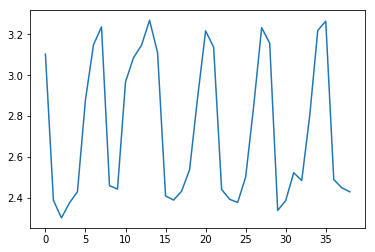

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.851070   
air_0164b9927d20bcc3_2017-04-23              1.406956   
air_0241aa3964b7f861_2017-04-23              2.391885   
air_0328696196e46f18_2017-04-23              2.100666   
air_034a3d5b40d5b1b1_2017-04-23              3.469722   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.366631  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.083507  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.934085  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.171613  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.127823

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l2_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')